In [1]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
root = '../data/phase_2/cleaned/'
os.listdir(root)

['col_names.pkl', 'train(energy).csv', 'train.csv', '現場數據.csv']

In [2]:
col_names = joblib.load(root+'col_names.pkl')
col_names.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'yld', 'Tray_temp', 'duty', 'Rate_m3', 'Rate_ton', 'sle', 'shc', 'she', 'case'])

In [3]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

# load data

In [4]:
df = pd.read_csv(root+'train.csv',index_col=0).dropna(axis=0)
print(df.shape)
df.head()

(16498, 403)


,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,Naphtha Properties_n-Pentane_wt%,Naphtha Properties_tr2-Pentene_wt%,Naphtha Properties_Cyclopentane_wt%,Naphtha Properties_3-Methylpentane_wt%,...,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene_Ratio",Individual Component to Heavy End Split Factor_n-Undecane_Ratio,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%
001-01,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.409138,0.433925,0.440811,0.451332,0.454764,1.0,10.0,2.5,100.0,1.0
001-02,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.397878,0.422758,0.429677,0.440263,0.443717,1.0,10.0,5.0,100.0,1.0
001-03,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.385311,0.410579,0.417606,0.428374,0.431884,1.0,10.0,10.0,100.0,1.0
001-04,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.387033,0.409416,0.415640,0.425230,0.428354,1.0,10.0,2.5,100.0,1.5
001-05,0.0,0.0,0.0,0.002,0.003,0.025999,0.073999,0.001,0.013,1.365973,...,0.376672,0.399048,0.405285,0.414893,0.418027,1.0,10.0,5.0,100.0,1.5


# calculate ratio

In [5]:
rle = df[col_names['fle']].values/df[col_names['fna']].values
rhc = df[col_names['fhc']].values/df[col_names['fna']].values
rhe = df[col_names['fhe']].values/df[col_names['fna']].values
ratio = pd.DataFrame(index=df.index)
ratio['rle'] = rle.ravel()
ratio['rhc'] = rhc.ravel()
ratio['rhe'] = rhe.ravel()
ratio

,rle,rhc,rhe
001-01,0.063244,0.848819,0.087937
001-02,0.067038,0.848928,0.084034
001-03,0.072795,0.849211,0.077995
001-04,0.057570,0.848342,0.094088
001-05,0.061068,0.848457,0.090474
...,...,...,...
500-29,0.035345,0.883726,0.080929
500-30,0.035277,0.883691,0.081032
500-31,0.035391,0.877314,0.087294
500-32,0.035368,0.877270,0.087363


# calculate density

In [6]:
density = df[col_names['Rate_ton']].values/df[col_names['Rate_m3']].values
density = pd.DataFrame(density,columns=['NA_density','LE_density','HC_density','HE_density'],index=df.index)
density.head()

,NA_density,LE_density,HC_density,HE_density
001-01,0.732839,0.683806,0.734016,0.760288
001-02,0.732839,0.686371,0.734110,0.760618
001-03,0.732839,0.688468,0.734355,0.761531
001-04,0.732839,0.683457,0.733602,0.759290
001-05,0.732839,0.686087,0.733705,0.759360


# duty

In [7]:
duty = df[col_names['duty']]
duty = duty.drop('Duty_Condenser Heat Duty_Mkcal/hr',axis=1)
duty.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr
001-01,2.280675,4.252277
001-02,2.280843,4.071568
001-03,2.280798,3.900158
001-04,2.280843,3.759819
001-05,2.280675,3.607212


# define X,Y

In [8]:
X = df[col_names['case']].join(df[col_names['xna']])
print(X.shape)
X.head()

(16498, 58)


,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
001-01,10.0,2.5,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-02,10.0,5.0,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-03,10.0,10.0,100.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-04,10.0,2.5,100.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-05,10.0,5.0,100.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0


In [9]:
Y = duty.join(density).join(ratio)
print(Y.shape)
Y.head()

(16498, 9)


,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density,rle,rhc,rhe
001-01,2.280675,4.252277,0.732839,0.683806,0.734016,0.760288,0.063244,0.848819,0.087937
001-02,2.280843,4.071568,0.732839,0.686371,0.734110,0.760618,0.067038,0.848928,0.084034
001-03,2.280798,3.900158,0.732839,0.688468,0.734355,0.761531,0.072795,0.849211,0.077995
001-04,2.280843,3.759819,0.732839,0.683457,0.733602,0.759290,0.057570,0.848342,0.094088
001-05,2.280675,3.607212,0.732839,0.686087,0.733705,0.759360,0.061068,0.848457,0.090474


# build scale

In [10]:
mm_x = MinMaxScaler()
mm_y = MinMaxScaler()

# scale features

In [11]:
X[:] = mm_x.fit_transform(X[:])
X.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
001-01,0.0,0.000000,0.5,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-02,0.0,0.333333,0.5,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-03,0.0,1.000000,0.5,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-04,0.0,0.000000,0.5,0.499165,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-05,0.0,0.333333,0.5,0.499165,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0


In [12]:
Y[:] = mm_y.fit_transform(Y[:])
Y.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density,rle,rhc,rhe
001-01,0.500376,0.299170,0.050789,0.292995,0.014472,0.051083,0.249285,0.739369,0.324808
001-02,0.500471,0.281120,0.050790,0.315001,0.015451,0.053848,0.264373,0.739850,0.307442
001-03,0.500445,0.263998,0.050790,0.332987,0.017995,0.061500,0.287268,0.741094,0.280569
001-04,0.500471,0.249981,0.050790,0.290005,0.010181,0.042718,0.226721,0.737269,0.352176
001-05,0.500376,0.234737,0.050789,0.312563,0.011254,0.043307,0.240635,0.737776,0.336097


# split train test

In [13]:
x_col = X.columns.tolist()
y_col = Y.columns.tolist()
df = shuffle(X.join(Y))

In [14]:
X = df[x_col]
Y = df[y_col]

sp1 = int(len(X)*0.8)
sp2 = int(len(X)*0.9)

X_train,Y_train = X.iloc[:sp1,:],Y.iloc[:sp1,:]
X_valid,Y_valid = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
X_test,Y_test = X.iloc[sp2:,:],Y.iloc[sp2:,:]

print(X_train.shape,X_valid.shape,X_test.shape)
print(Y_train.shape,Y_valid.shape,Y_test.shape)

(13198, 58) (1650, 58) (1650, 58)
(13198, 9) (1650, 9) (1650, 9)


# to torch tensor

In [15]:
X_train = torch.tensor(X_train.values,dtype=torch.float)#.cuda()
X_valid = torch.tensor(X_valid.values,dtype=torch.float)#.cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float)#.cuda()

Y_train = torch.tensor(Y_train.values,dtype=torch.float)#.cuda()
Y_valid = torch.tensor(Y_valid.values,dtype=torch.float)#.cuda()
Y_test = torch.tensor(Y_test.values,dtype=torch.float)#.cuda()

# data iter

In [16]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [17]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [18]:
class energy_net(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(energy_net,self).__init__()
        self.fc1 = Linear(input_shape,128)
        self.fc2 = Linear(128,128)
        self.fc3 = Linear(128,output_shape)
    
    def forward(self,x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [19]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [20]:
net = energy_net(len(x_col),len(y_col))#.cuda()
net.apply(init_weights)

energy_net(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=9, bias=True)
)

# forward test

In [21]:
net(X_test)

tensor([[0.4840, 0.5346, 0.4214,  ..., 0.3693, 0.5043, 0.6020],
        [0.4319, 0.5492, 0.4295,  ..., 0.3670, 0.5076, 0.5720],
        [0.4528, 0.5421, 0.3973,  ..., 0.3726, 0.5122, 0.5951],
        ...,
        [0.5660, 0.5668, 0.4721,  ..., 0.4082, 0.5318, 0.5363],
        [0.4706, 0.5122, 0.4848,  ..., 0.4365, 0.5121, 0.5666],
        [0.4731, 0.5388, 0.4327,  ..., 0.3640, 0.5076, 0.6082]],
       grad_fn=<SigmoidBackward>)

# torchviz

In [22]:
#y = net(X_test)
#torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))

# tensorboard

In [23]:
#with SummaryWriter(comment='Net')as w:
#    w.add_graph(net, (X_test,))

# loss_function and optimizer

In [24]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# train_loop

In [25]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0103 valid loss 0.0029
record net
epochs 1 train loss 0.0022 valid loss 0.0018
record net
epochs 2 train loss 0.0016 valid loss 0.0014
record net
epochs 3 train loss 0.0012 valid loss 0.0012
record net
epochs 4 train loss 0.0011 valid loss 0.0011
record net
epochs 5 train loss 0.0010 valid loss 0.0011
epochs 6 train loss 0.0010 valid loss 0.0010
record net
epochs 7 train loss 0.0010 valid loss 0.0010
record net
epochs 8 train loss 0.0009 valid loss 0.0010
record net
epochs 9 train loss 0.0009 valid loss 0.0010
epochs 10 train loss 0.0009 valid loss 0.0010
record net
epochs 11 train loss 0.0009 valid loss 0.0009
record net
epochs 12 train loss 0.0009 valid loss 0.0009
record net
epochs 13 train loss 0.0008 valid loss 0.0008
record net
epochs 14 train loss 0.0008 valid loss 0.0008
record net
epochs 15 train loss 0.0008 valid loss 0.0008
record net
epochs 16 train loss 0.0008 valid loss 0.0008
record net
epochs 17 train loss 0.0007 valid loss 0.0008
record net
epochs

epochs 161 train loss 0.0001 valid loss 0.0001
epochs 162 train loss 0.0001 valid loss 0.0001
epochs 163 train loss 0.0001 valid loss 0.0001
epochs 164 train loss 0.0001 valid loss 0.0001
record net
epochs 165 train loss 0.0001 valid loss 0.0001
epochs 166 train loss 0.0001 valid loss 0.0001
epochs 167 train loss 0.0001 valid loss 0.0001
epochs 168 train loss 0.0001 valid loss 0.0001
epochs 169 train loss 0.0001 valid loss 0.0001
epochs 170 train loss 0.0001 valid loss 0.0001
epochs 171 train loss 0.0001 valid loss 0.0001
epochs 172 train loss 0.0001 valid loss 0.0001
epochs 173 train loss 0.0001 valid loss 0.0001
epochs 174 train loss 0.0001 valid loss 0.0001
record net
epochs 175 train loss 0.0001 valid loss 0.0001
epochs 176 train loss 0.0001 valid loss 0.0001
epochs 177 train loss 0.0001 valid loss 0.0001
epochs 178 train loss 0.0001 valid loss 0.0001
epochs 179 train loss 0.0001 valid loss 0.0002
epochs 180 train loss 0.0001 valid loss 0.0001
epochs 181 train loss 0.0001 valid los

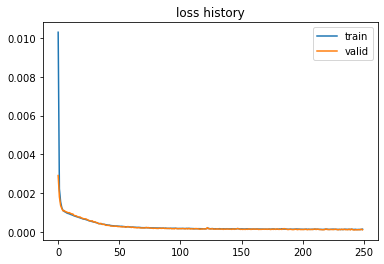

In [26]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=250)

# make prediction

In [27]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = mm_y.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density,rle,rhc,rhe
0,2.223324,3.943999,0.736689,0.690542,0.737013,0.771028,0.054980,0.868739,0.076570
1,2.313552,4.518020,0.737932,0.699573,0.739434,0.760601,0.078084,0.836182,0.084969
2,2.229171,3.286275,0.736673,0.689221,0.737090,0.763764,0.050498,0.868612,0.080803
3,2.387652,4.066794,0.745254,0.681850,0.752265,0.771824,0.112104,0.812624,0.075528
4,2.519850,4.196175,0.743382,0.681502,0.754490,0.770852,0.153709,0.775395,0.070938


In [28]:
y_real = Y_test.cpu().detach().numpy()
y_real = mm_y.inverse_transform(y_real)
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density,rle,rhc,rhe
0,2.229134,4.036461,0.736707,0.690363,0.736920,0.770585,0.054679,0.867556,0.077765
1,2.311599,4.605011,0.737900,0.699770,0.739384,0.760852,0.078117,0.836403,0.085480
2,2.228984,3.372720,0.736707,0.689205,0.737065,0.764679,0.049857,0.867724,0.082419
3,2.383777,4.133917,0.744854,0.682052,0.751762,0.772737,0.110741,0.813931,0.075328
4,2.506744,4.251051,0.743193,0.682099,0.753919,0.771551,0.152341,0.777340,0.070319


# metric

In [29]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.972831,0.000608882,0.316331
Duty_Reboiler Heat Duty_Mkcal/hr,0.960636,0.0444232,2.13048
NA_density,0.999162,1.14466e-07,0.0309246
LE_density,0.994031,9.01257e-07,0.0786607
HC_density,0.998973,1.48859e-07,0.0387213
HE_density,0.990799,1.99701e-06,0.113342
rle,0.999051,1.44891e-06,2.59693
rhc,0.994105,7.76322e-06,0.183159
rhe,0.93504,7.45362e-06,1.81895
AVG,0.982736,0.00500577,0.811945


# wrap model

In [30]:
class ANN_energy_wrapper(object):
    def __init__(self,x_col,y_col,mm_x,mm_y,net):
        self.x_col = x_col
        self.y_col = y_col
        self.mm_x = mm_x
        self.mm_y = mm_y
        self.net = net
    
    def predict(self,x):
        x = self.mm_x.transform(x)
        x = torch.tensor(x,dtype=torch.float)#.cuda()
        y = self.net(x).detach().cpu().numpy()
        y = self.mm_y.inverse_transform(y)
        y = pd.DataFrame(y,columns=self.y_col)
        y.iloc[:,-3:] = self.normalize(y.iloc[:,-3:].values)
        assert np.all(y.values >= 0)
        assert y.iloc[:,-3:].sum(axis=1).mean() == 1
        return y
    
    def normalize(self,x):
        return x / x.sum(axis=1).reshape(-1,1)

In [31]:
model = ANN_energy_wrapper(x_col,y_col,mm_x,mm_y,net.eval())

# test ANN_wrapper

In [32]:
X_test = mm_x.inverse_transform(X_test.detach().cpu().numpy())
X_test = pd.DataFrame(X_test,columns=x_col)
X_test.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
0,20.0,10.0,100.0,0.7,0.0,0.0,0.0,0.002000,0.004000,0.035999,...,1.742930,4.068837,0.647974,0.499980,0.922963,0.094996,0.053998,0.002,0.010,0.0
1,10.0,2.5,100.0,1.0,0.0,0.0,0.0,0.010000,0.021001,0.171005,...,1.340040,3.128093,0.401012,0.894027,0.389012,0.169005,0.023001,0.003,0.004,0.0
2,10.0,10.0,100.0,1.0,0.0,0.0,0.0,0.002000,0.004000,0.035999,...,1.742930,4.068837,0.647974,0.499980,0.922963,0.094996,0.053998,0.002,0.010,0.0
3,10.0,5.0,100.0,1.0,0.0,0.0,0.0,0.053998,0.108997,0.901973,...,1.024969,2.392928,0.819975,0.900973,0.784976,0.169995,0.045999,0.003,0.009,0.0
4,30.0,10.0,100.0,2.0,0.0,0.0,0.0,0.085001,0.170002,1.410014,...,1.016010,2.372024,0.787008,0.703007,0.336003,0.133001,0.020000,0.002,0.004,0.0


In [33]:
Y_test = mm_y.inverse_transform(Y_test.detach().cpu().numpy())
Y_test = pd.DataFrame(Y_test,columns=y_col)
Y_test.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density,rle,rhc,rhe
0,2.229134,4.036461,0.736707,0.690363,0.736920,0.770585,0.054679,0.867556,0.077765
1,2.311599,4.605011,0.737900,0.699770,0.739384,0.760852,0.078117,0.836403,0.085480
2,2.228984,3.372720,0.736707,0.689205,0.737065,0.764679,0.049857,0.867724,0.082419
3,2.383777,4.133917,0.744854,0.682052,0.751762,0.772737,0.110741,0.813931,0.075328
4,2.506744,4.251051,0.743193,0.682099,0.753919,0.771551,0.152341,0.777340,0.070319


In [34]:
Y_pred = model.predict(X_test)
Y_pred.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density,rle,rhc,rhe
0,2.223324,3.943999,0.736689,0.690542,0.737013,0.771028,0.054964,0.868488,0.076548
1,2.313552,4.518020,0.737932,0.699573,0.739434,0.760601,0.078143,0.836823,0.085034
2,2.229171,3.286275,0.736673,0.689221,0.737090,0.763764,0.050503,0.868687,0.080810
3,2.387652,4.066794,0.745254,0.681850,0.752265,0.771824,0.112075,0.812416,0.075509
4,2.519850,4.196176,0.743382,0.681502,0.754490,0.770852,0.153703,0.775362,0.070935


# metric

In [35]:
y_real = Y_test
y_pred = Y_pred

In [36]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.972831,0.000608882,0.316331
Duty_Reboiler Heat Duty_Mkcal/hr,0.960636,0.0444233,2.13048
NA_density,0.999162,1.14466e-07,0.0309246
LE_density,0.994031,9.01258e-07,0.0786608
HC_density,0.998973,1.48859e-07,0.0387214
HE_density,0.990799,1.99701e-06,0.113342
rle,0.999064,1.42959e-06,2.59511
rhc,0.994056,7.82858e-06,0.182755
rhe,0.935918,7.35282e-06,1.79224
AVG,0.98283,0.00500577,0.808729


# save model

In [37]:
joblib.dump(model,'../model/ANN(energy).pkl')
print('save done!')

save done!
